<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 6.3
# *KNN classification Lab*

**In this lab, we will:**
- Practice KNN classification on a dataset of breast cancer.
- Predict the `diagnoosis` of a patient from predictor variables of your choice.

### 1. Load Data

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server: ftp ftp.cs.wisc.edu cd math-prog/cpo-dataset/machine-learn/WDBC/

Also can be found on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Attribute Information:

1) ID number 2) Diagnosis (M = malignant, B = benign) 3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter) b) texture (standard deviation of gray-scale values) c) perimeter d) area e) smoothness (local variation in radius lengths) f) compactness (perimeter^2 / area - 1.0) g) concavity (severity of concave portions of the contour) h) concave points (number of concave portions of the contour) i) symmetry j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

In [15]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('breast-cancer-wisconsin-data.csv')

### 2. EDA

Explore dataset. Clean data. Find correlation.

In [3]:
print(data.head())
print(data.info())

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness

In [5]:
data = data.drop('id', axis=1)
if 'Unnamed: 32' in data.columns:
    data = data.drop('Unnamed: 32', axis=1)

In [6]:
# Check for missing values
print(data.isnull().sum())

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


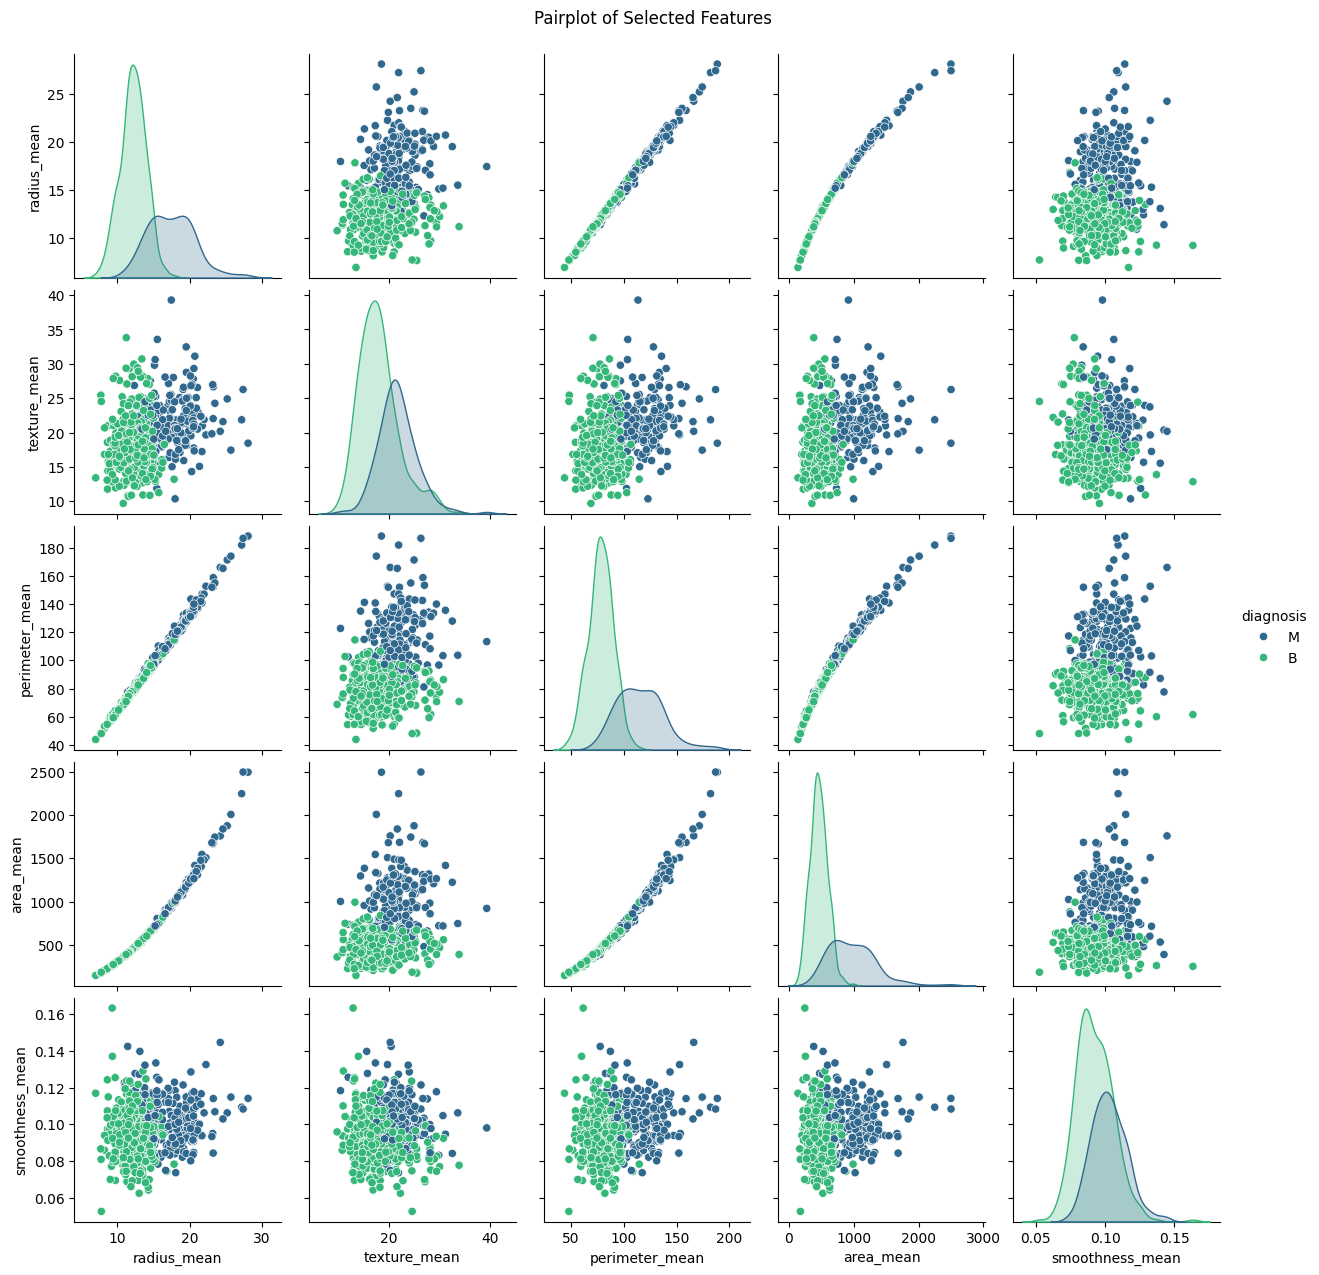

In [9]:
# Pairplot
sns.pairplot(data[['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'diagnosis']], 
             hue='diagnosis', palette='viridis')
plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()

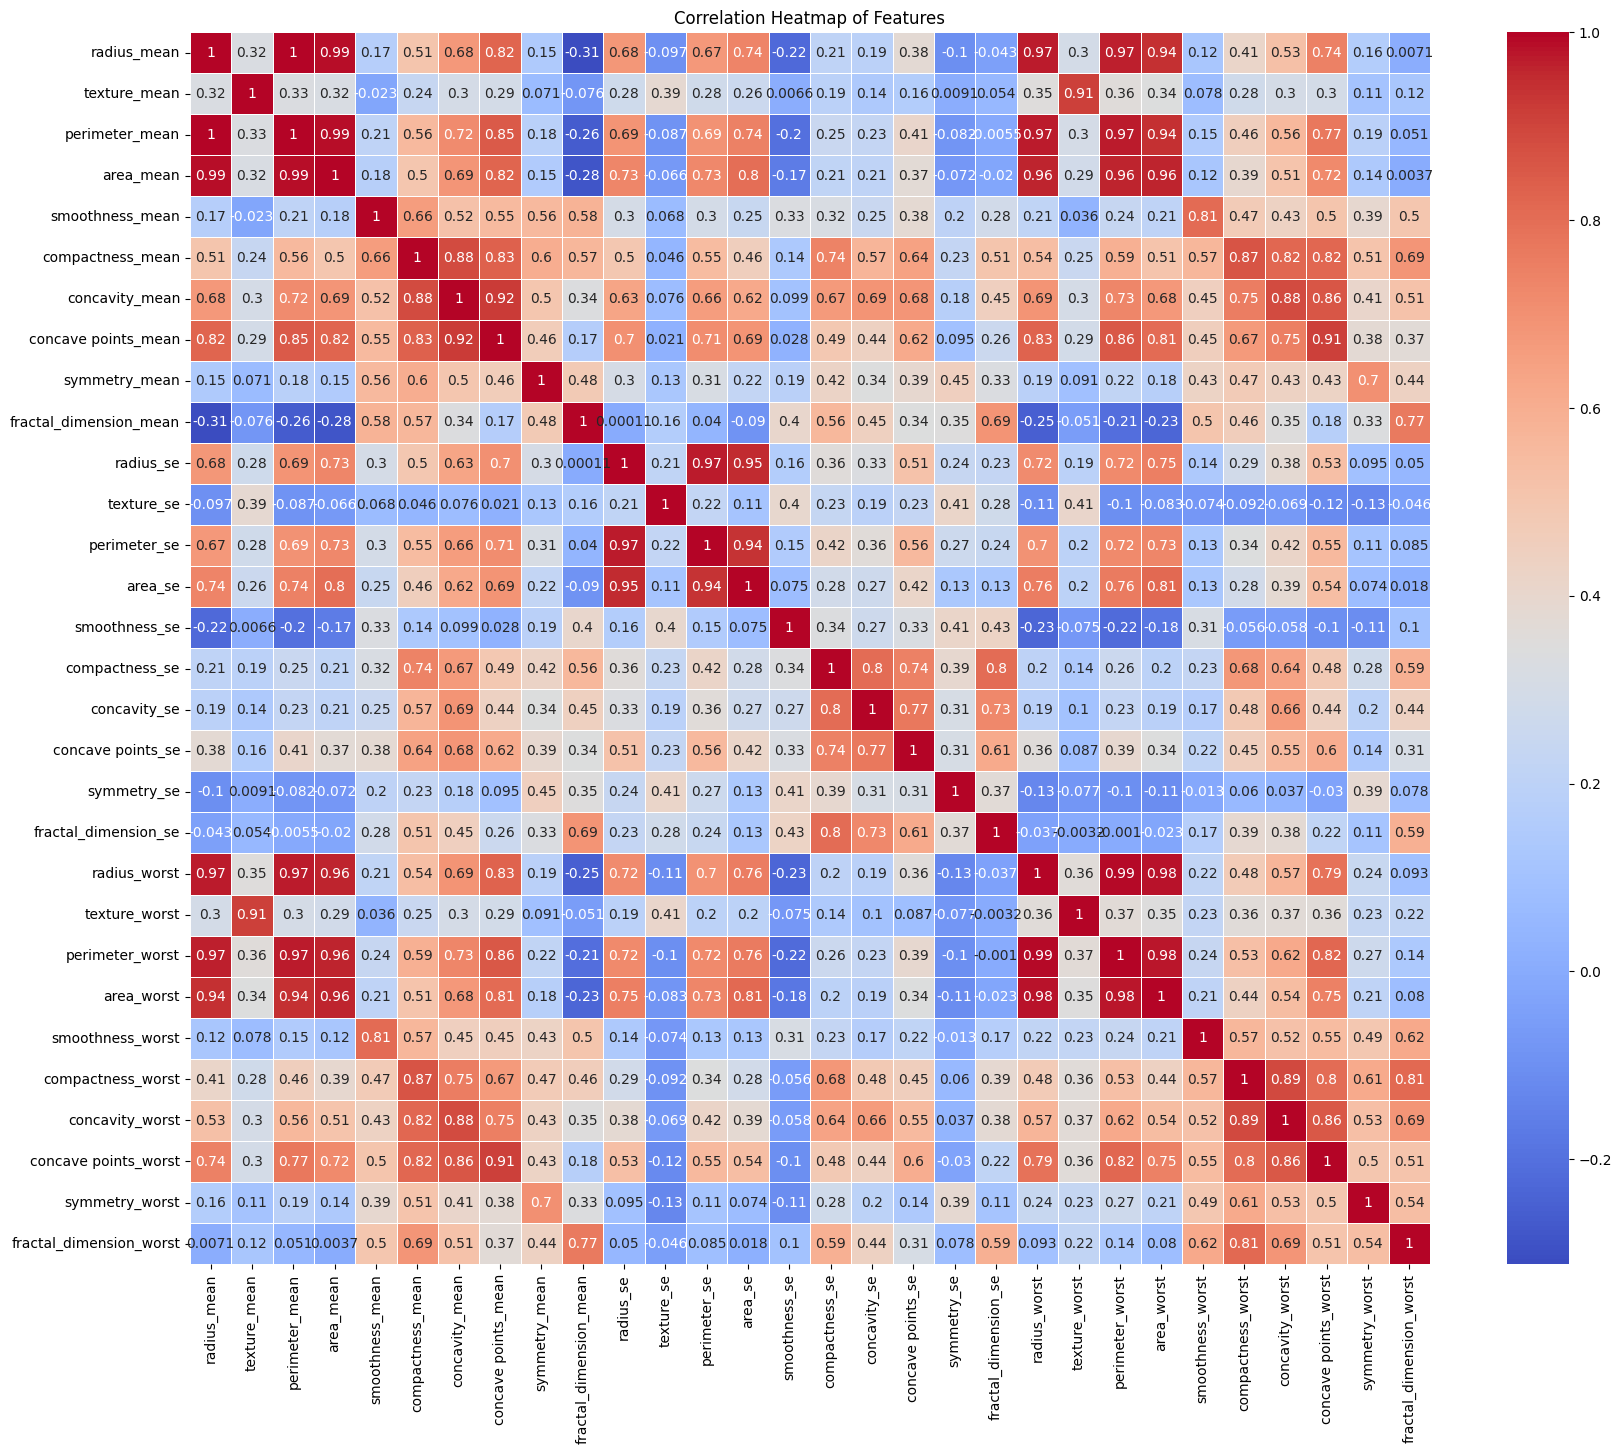

In [10]:
# Correlation heatmap
plt.figure(figsize=(20,16))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

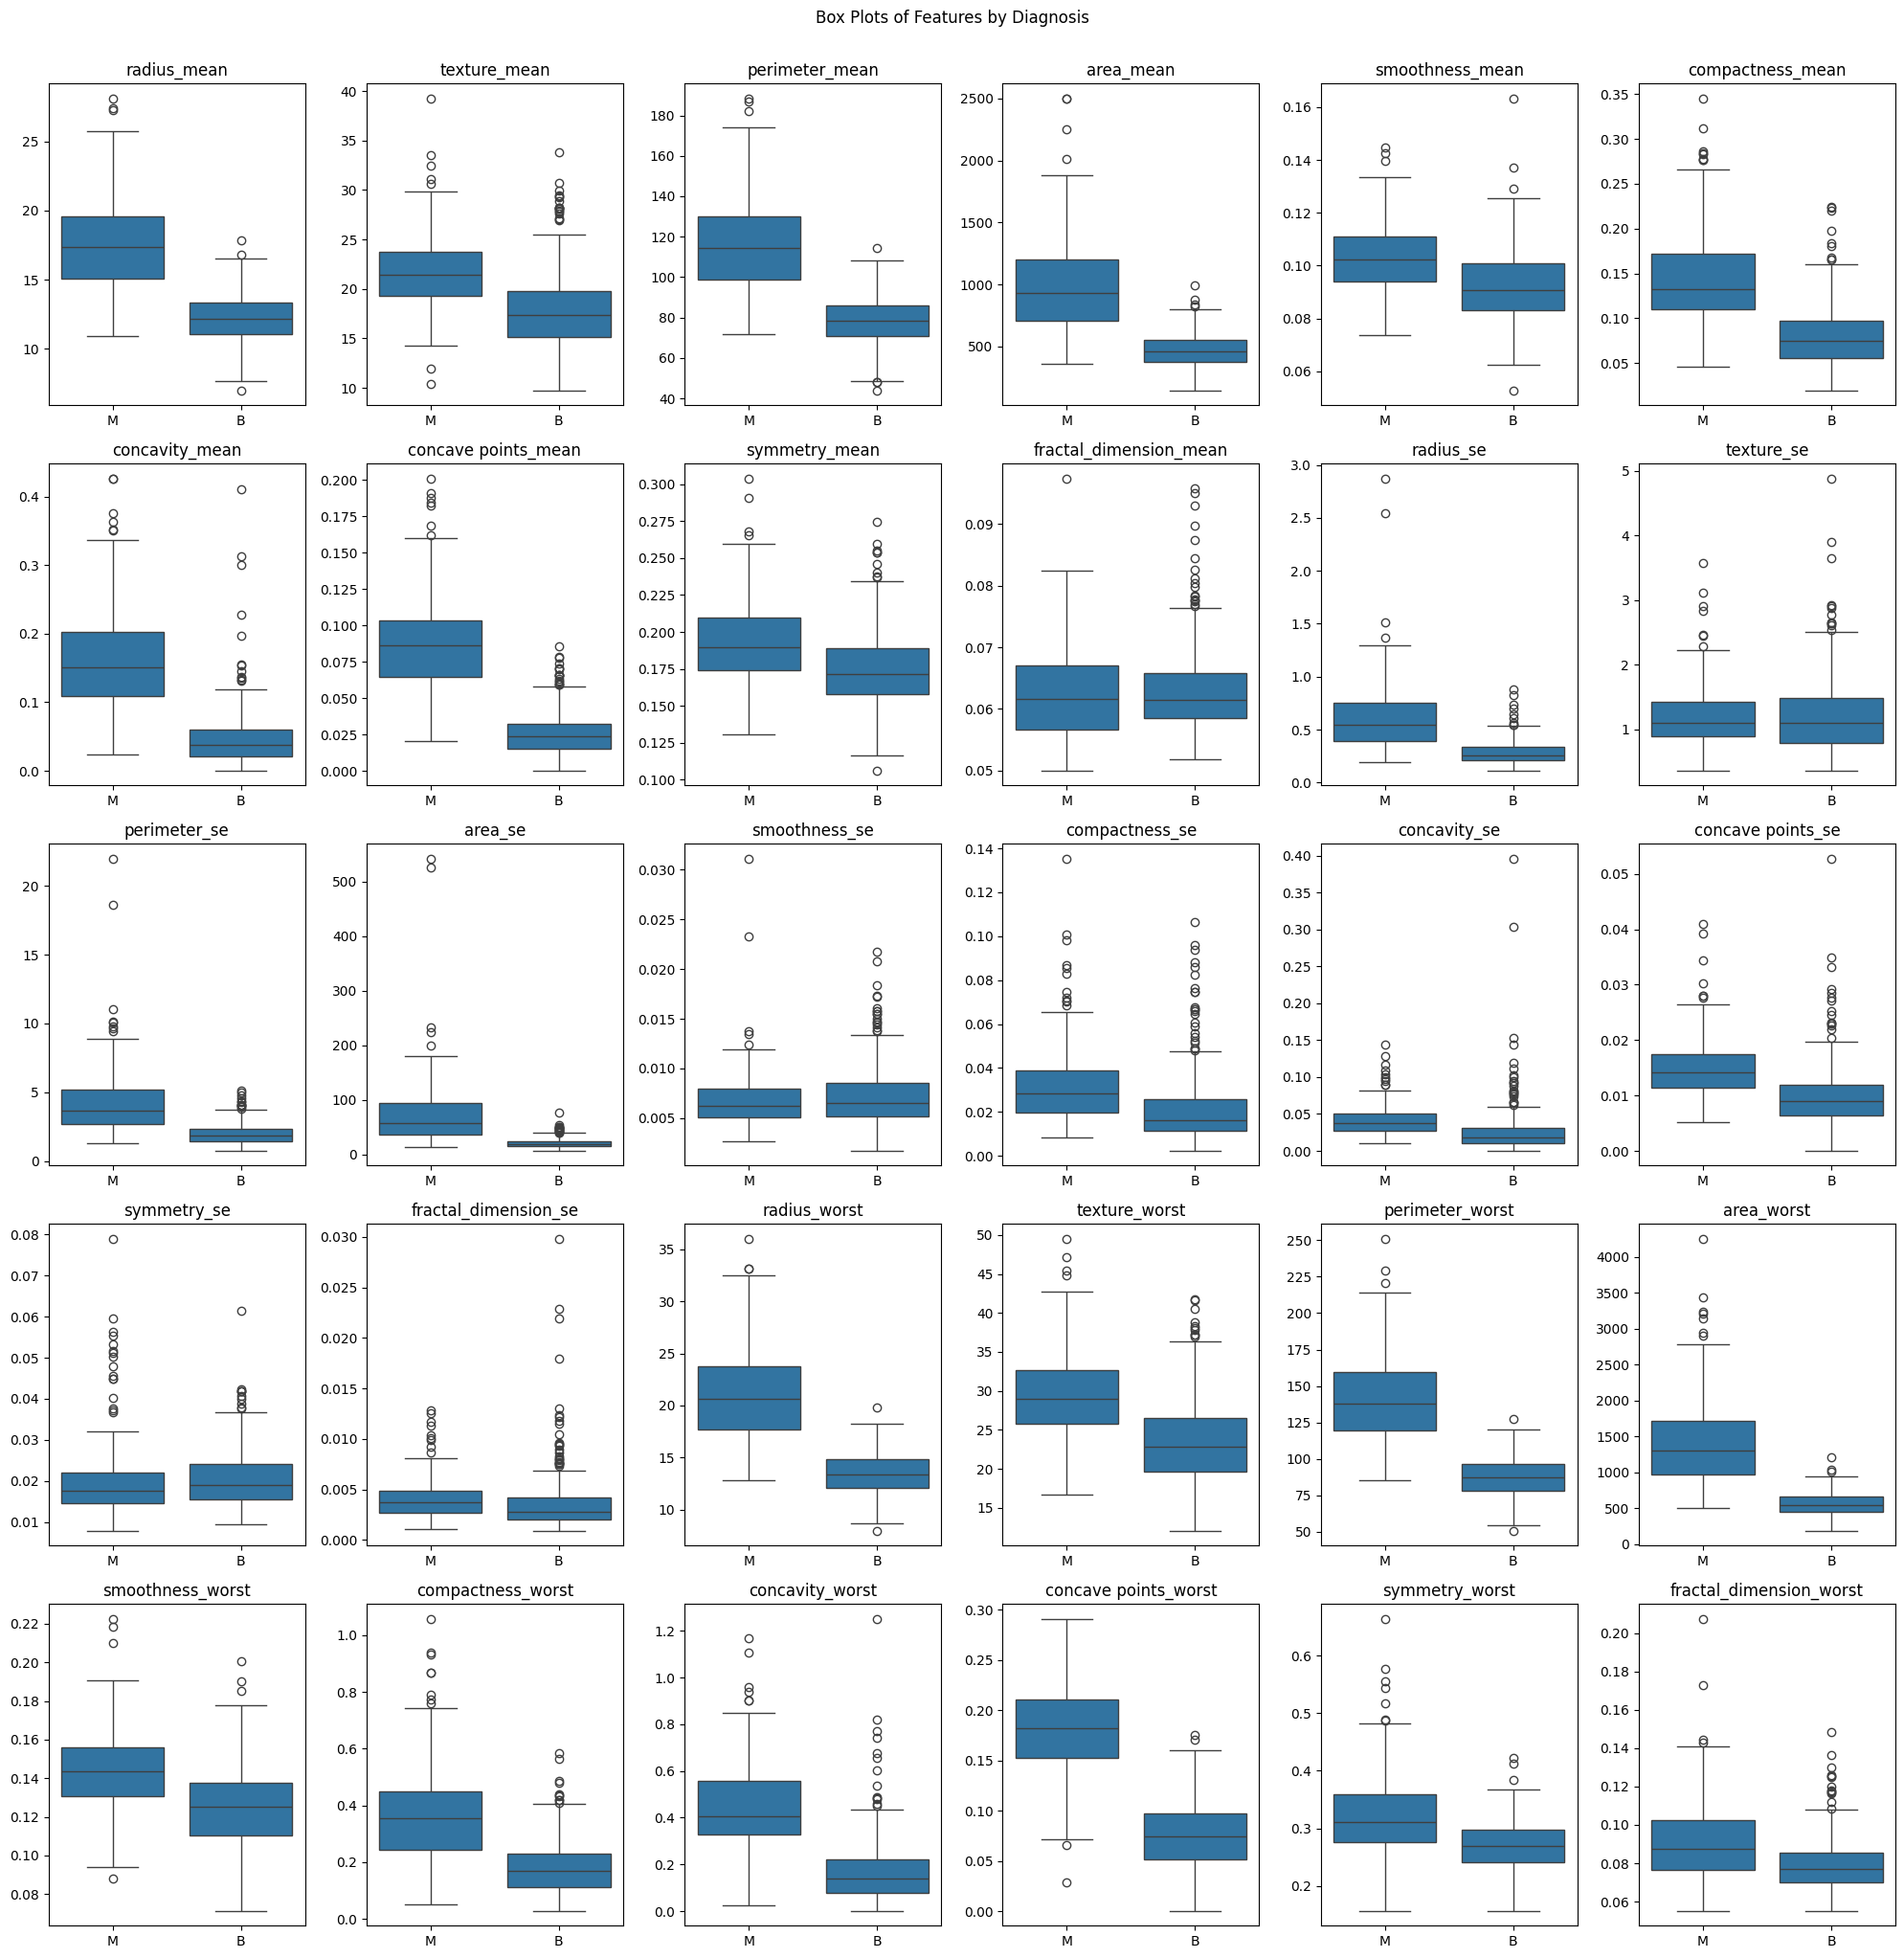

In [11]:
# Box plots
fig, axes = plt.subplots(5, 6, figsize=(20, 20))
axes = axes.flatten()
for i, col in enumerate(X.columns):
    sns.boxplot(x=data['diagnosis'], y=data[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
plt.tight_layout()
plt.suptitle('Box Plots of Features by Diagnosis', y=1.02)
plt.show()

### 3. Set up the `diagnosis` variable as your target. How many classes are there?

In [8]:
# ANSWER
# Set up the target variable
y = data['diagnosis']
X = data.drop('diagnosis', axis=1)

# Check class distribution
print(y.value_counts(normalize=True))

diagnosis
B    0.627417
M    0.372583
Name: proportion, dtype: float64


### 4. What is the baseline accuracy?

In [12]:
# ANSWER
class_distribution = y.value_counts(normalize=True)
baseline_accuracy = class_distribution.max()
print(f"Class distribution:\n{class_distribution}")
print(f"Baseline accuracy: {baseline_accuracy:.4f}")

Class distribution:
diagnosis
B    0.627417
M    0.372583
Name: proportion, dtype: float64
Baseline accuracy: 0.6274


In [13]:
# Correlation with target
correlation_with_target = X.corrwith(y.map({'M': 1, 'B': 0})).abs().sort_values(ascending=False)
print("\nCorrelation with target (top 10):")
print(correlation_with_target.head(10))


Correlation with target (top 10):
concave points_worst    0.793566
perimeter_worst         0.782914
concave points_mean     0.776614
radius_worst            0.776454
perimeter_mean          0.742636
area_worst              0.733825
radius_mean             0.730029
area_mean               0.708984
concavity_mean          0.696360
concavity_worst         0.659610
dtype: float64


### 5. Choose features to be your predictor variables and set up your X.

In [14]:
# ANSWER
selected_features = [
    'radius_worst', 'perimeter_worst', 'area_worst',  # Size-related worst features
    'concave points_worst', 'concavity_worst',        # Shape-related worst features
    'radius_mean', 'perimeter_mean', 'area_mean',     # Size-related mean features
    'concave points_mean', 'concavity_mean',          # Shape-related mean features
    'texture_worst', 'smoothness_worst'               # Texture-related features
]

X_selected = X[selected_features]

print("\nSelected features:")
print(X_selected.columns.tolist())


Selected features:
['radius_worst', 'perimeter_worst', 'area_worst', 'concave points_worst', 'concavity_worst', 'radius_mean', 'perimeter_mean', 'area_mean', 'concave points_mean', 'concavity_mean', 'texture_worst', 'smoothness_worst']


### 6. Fit a `KNeighborsClassifier` with 1 neighbor using the target and predictors.

In [16]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [17]:
# ANSWER

# Make an instance of a KNeighborsClassifier object with 1 neighbor
knn = KNeighborsClassifier(n_neighbors=1)

# Fit on the unstandardized data
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

### 7. Evaluate the accuracy of your model.
- Is it better than baseline?
- Is it legitimate?

In [19]:
# ANSWER
# predict the response values for the observations in X ("test the model")
# Make predictions
y_pred = knn.predict(X_test)
# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
# store the predicted response values


### 8. Create a 80-20 train-test-split of your target and predictors. Refit the KNN and assess the accuracy.

In [ ]:
# ANSWER
# STEP 1: split X and y into training and testing sets (using random_state for reproducibility)

# STEP 2: train the model on the training set (using K=1)

# STEP 3: test the model on the testing set, and check the accuracy

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of KNN (k=1) with 80-20 split: {accuracy:.4f}")

Accuracy of KNN (k=1) with 80-20 split: 0.9123


### 9. Evaluate the test accuracy of a KNN where K == number of rows in the training data.

In [ ]:
# ANSWER
# Create an instance of KNeighborsClassifier where n_neighbors = number of rows in the training data

# Fit Train Data

# Print accuracy_score

In [23]:
k_max = X_train.shape[0]
knn_max = KNeighborsClassifier(n_neighbors=k_max)
knn_max.fit(X_train, y_train)
y_pred_max = knn_max.predict(X_test)
accuracy_max = accuracy_score(y_test, y_pred_max)
print(f"Accuracy of KNN (k={k_max}): {accuracy_max:.4f}")

Accuracy of KNN (k=455): 0.6228


### 10. Fit the KNN at values of K from 1 to the number of rows in the training data.
- Store the test accuracy in a list.
- Plot the test accuracy vs. the number of neighbors.

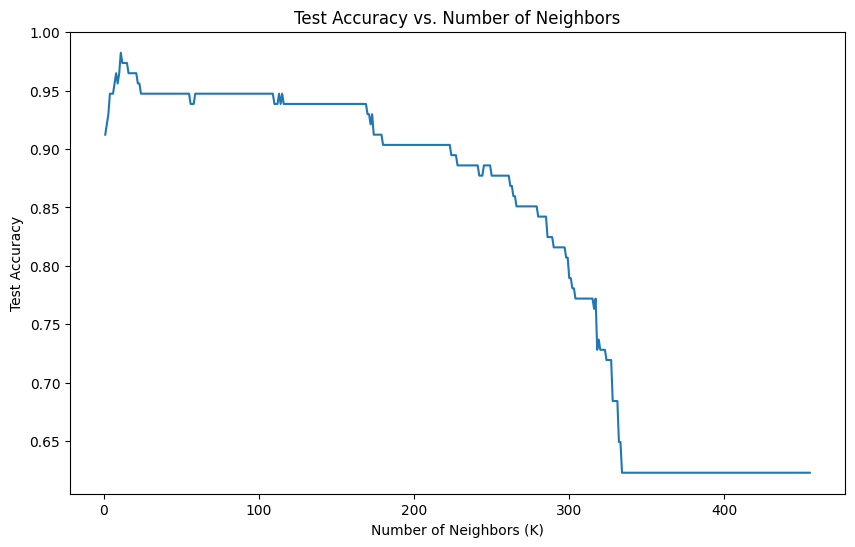

In [24]:
# ANSWER
# plot test accuracy by number of neighbors:
k_values = range(1, k_max + 1)
test_accuracy = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    test_accuracy.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(k_values, test_accuracy)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Number of Neighbors')
plt.show()


### 11. Fit KNN across different values of K and plot the mean cross-validated accuracy with 5 folds.


In [ ]:
# ANSWER

k= 1

Five models - five fold - average accuracy - cv. SKlearn

k = 2
.
.
.
k=n

In [27]:
import warnings
warnings.filterwarnings('ignore')

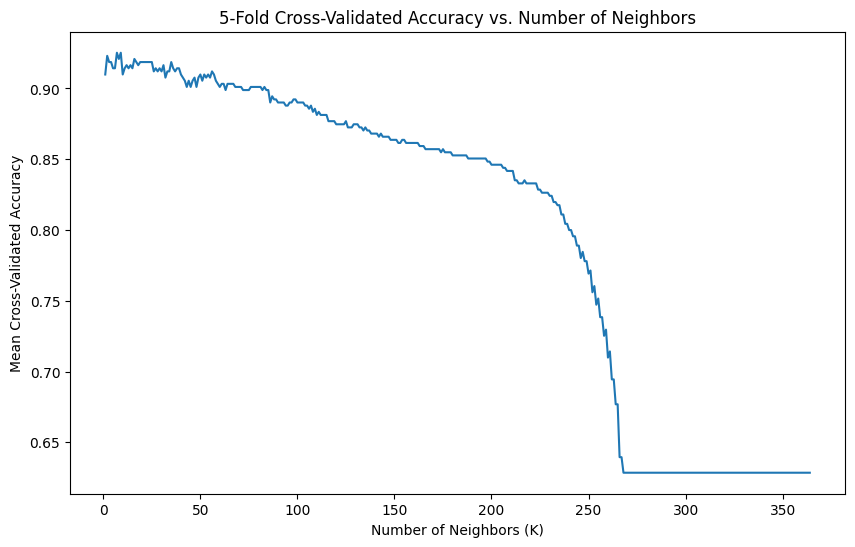

In [28]:
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Mean Cross-Validated Accuracy')
plt.title('5-Fold Cross-Validated Accuracy vs. Number of Neighbors')
plt.show()

### 12. Standardize the predictor matrix and cross-validate across the different K.
- Plot the standardized mean cross-validated accuracy against the unstandardized. Which is better?
- Why?

In [ ]:
# ANSWER
# Standarize X

In [ ]:
# ANSWER
# plot test accuracy by number of neighbors:

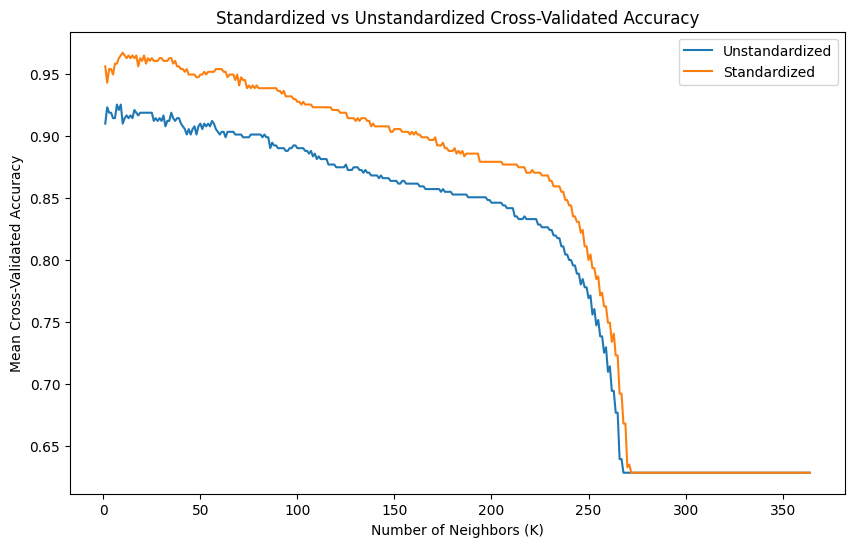

Which is better?
Standardized data performs better.

Why?
Standardization can improve KNN performance when features are on different scales.
It ensures that all features contribute equally to the distance calculations.
However, if features are already on similar scales, the impact might be minimal.
The specific dataset characteristics determine whether standardization helps.


In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

cv_scores_standardized = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores_standardized.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, label='Unstandardized')
plt.plot(k_values, cv_scores_standardized, label='Standardized')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Mean Cross-Validated Accuracy')
plt.title('Standardized vs Unstandardized Cross-Validated Accuracy')
plt.legend()
plt.show()

print("Which is better?")
if max(cv_scores_standardized) > max(cv_scores):
    print("Standardized data performs better.")
else:
    print("Unstandardized data performs better.")

print("\nWhy?")
print("Standardization can improve KNN performance when features are on different scales.")
print("It ensures that all features contribute equally to the distance calculations.")
print("However, if features are already on similar scales, the impact might be minimal.")
print("The specific dataset characteristics determine whether standardization helps.")

**References**

[Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/downloads/breast-cancer-wisconsin-data.zip/2)



---



---



> > > > > > > > > © 2024 Institute of Data


---



---



